# Geometric Brownian Motion Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/geometric_brownian_motion/demos/gbm_demo.ipynb)

Larysa Matiukha, Aleksei Sorokin, and Sou-Cheng T. Choi

Illinois Institute of Technology

Modification date: 09/04/2025

Creation date: 08/24/2024

For reproducibility, this notebook was run with:
- Python 3.9.13, NumPy 1.23.4, SciPy 1.9.3, QMCPy 2.0, QuantLib 1.38, Matplotlib 3.5.2, ipywidgets 8.1.7, perfplot 0.10.2 
- OS: macOS 15.6.1
- Random seeds: 42 (QMCPy), 7 (QuantLib)

In [1]:
try:
    import qmcpy as qp
except ModuleNotFoundError:
    !pip install -q qmcpy

In [2]:
import qmcpy as qp
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import os

import latex_util as lu
import plot_util as pu
import data_util as du
import quantlib_util as qlu
import qmcpy_util as qpu
import config as cf

In [3]:
# Create output directory
os.makedirs('outputs', exist_ok=True)
os.makedirs('images', exist_ok=True)

Geometric Brownian motion (GBM) is a continuous stochastic process in which the natural logarithm of its values follows a Brownian motion. $[1]$

Mathematically, it can be defined as follows:

$\large{S_t = S_0 \, e^{\big(\mu - \frac{\sigma^2}{2}\big)  t + \sigma W_t}}$, 

where
* $S_0$ is the initial value, 
* $\mu$ is a drift coefficient
* $\sigma$ is difussion coefficient  
* $W_t$ is a (standard) Brownian motion.

GBM is commonly used to model stock prices and options payoffs. 

## GBM object in QMCPy

Geometric Brownian Motion in QMCPy inherits from BrownianMotion class $[2, 3]$. 

Let's explore the constructor and sample generation methods through the built-in help documentation:

In [4]:
help(qp.GeometricBrownianMotion.__init__)

Help on function __init__ in module qmcpy.true_measure.geometric_brownian_motion:

__init__(self, sampler, t_final=1, initial_value=1, drift=0, diffusion=1, decomp_type='PCA')
    Args:
        sampler (DiscreteDistribution/TrueMeasure): A discrete distribution or true measure.
        t_final (float): End time for the geometric Brownian motion, non-negative.
        initial_value (float): Positive initial value of the process, $S_0$.
        drift (float): Drift coefficient $\gamma$.
        diffusion (float): Positive diffusion coefficient $\sigma^2$.
        decomp_type (str): Method of decomposition, either "PCA" or "Cholesky".



In [5]:
help(qp.GeometricBrownianMotion.gen_samples)

Help on function gen_samples in module qmcpy.true_measure.abstract_true_measure:

gen_samples(self, n=None, n_min=None, n_max=None, return_weights=False, warn=True)



Now let's create a simple GBM instance and generate sample paths to see the class in action:

In [6]:
gbm = qp.GeometricBrownianMotion(qp.Lattice(2, seed=42))
gbm

GeometricBrownianMotion (AbstractTrueMeasure)
    time_vec        [0.5 1. ]
    drift           0
    diffusion       1
    mean_gbm        [1. 1.]
    covariance_gbm  [[0.649 0.649]
                     [0.649 1.718]]
    decomp_type     PCA

In [7]:
gbm.gen_samples(n=4)  # print four samples

array([[0.72608046, 0.70071241],
       [0.38739775, 0.07432173],
       [0.81262942, 1.66867239],
       [0.619371  , 0.31898397]])

### Log-Normality Property

At any time $t > 0$, $S_t$ follows a log-normal distribution with expected value and variance as follows (see Section 3.2 in $[1]$):

- $E[S_t] = S_0 e^{\mu t}$
- $\text{Var}[S_t] = S_0^2 e^{2\mu t}(e^{\sigma^2 t} - 1)$

Let's validate these theoretical properties by generating a large number of GBM samples and comparing the empirical moments with the theoretical values. Note that the theoretical values match the last values in `qp_gbm.mean_gbm` and `qp_gbm.covariance_gbm` for the final time point.

In [8]:
# Generate GBM samples for theoretical validation
S0, mu, sigma, T, n_samples = 100.0, 0.05, 0.20, 1.0, 2**12
diffusion = sigma**2
sampler = qp.Lattice(5, seed=42)
qp_gbm = qp.GeometricBrownianMotion(sampler, t_final=T, initial_value=S0, drift=mu, diffusion=diffusion)
paths = qp_gbm.gen_samples(n_samples)
S_T = paths[:, -1]  # Final values only

# Calculate theoretical vs empirical sample moments
theo_mean = S0 * np.exp(mu * T)
theo_var = S0**2 * np.exp(2*mu*T) * (np.exp(diffusion * T) - 1)
qp_emp_mean = np.mean(S_T)
qp_emp_var = np.var(S_T, ddof=1) 
print(f"Mean: {qp_emp_mean:.3f} (theoretical: {theo_mean:.3f})")
print(f"Variance: {qp_emp_var:.3f} (theoretical: {theo_var:.3f})")
qp_gbm

Mean: 105.127 (theoretical: 105.127)
Variance: 449.776 (theoretical: 451.029)


GeometricBrownianMotion (AbstractTrueMeasure)
    time_vec        [0.2 0.4 0.6 0.8 1. ]
    drift           0.050
    diffusion       0.040
    mean_gbm        [101.005 102.02  103.045 104.081 105.127]
    covariance_gbm  [[ 81.943  82.767  83.599  84.439  85.288]
                     [ 82.767 167.869 169.556 171.26  172.981]
                     [ 83.599 169.556 257.923 260.516 263.134]
                     [ 84.439 171.26  260.516 352.258 355.798]
                     [ 85.288 172.981 263.134 355.798 451.029]]
    decomp_type     PCA

## GMB vs Brownian Motion

Below we compare Brownian motion and geometric Brownian motion using the same parameters: `drift` = 0, `diffusion` = 1, `initial_value` = 1.


First, let's define a utility function that will help us visualize GBM paths with different samplers and parameters:

In [9]:
def plot_paths(motion_type, sampler, t_final, initial_value, drift, diffusion, n, png_filename=None):
    if motion_type.upper() == 'BM':
        motion = qp.BrownianMotion(sampler, t_final, initial_value, drift, diffusion)
        title = f'Realizations of Brownian Motion using {type(sampler).__name__} points'
        ylabel = '$W(t)$'
    elif motion_type.upper() == 'GBM':
        motion = qp.GeometricBrownianMotion(sampler, t_final, initial_value, drift, diffusion)
        title = f'Realizations of Geometric Brownian Motion using {type(sampler).__name__} points'
        ylabel = '$S(t)$'
    else:
        raise ValueError("motion_type must be 'BM' or 'GBM'")
    
    t = motion.gen_samples(n)
    initial_values = np.full((n, 1), motion.initial_value)
    t_w_init = np.hstack((initial_values, t))
    tvec_w_0 = np.hstack(([0], motion.time_vec))

    plt.figure(figsize=(7, 4));
    _ = plt.plot(tvec_w_0, t_w_init.T); 
    _ = plt.title(title);
    _ = plt.xlabel('$t$');
    _ = plt.ylabel(ylabel);
    _ = plt.xlim([tvec_w_0[0], tvec_w_0[-1]]);
    if png_filename:   # save .png to images/
        os.makedirs('images', exist_ok=True)
        plt.savefig(f'images/{png_filename}.png', bbox_inches='tight');
    plt.show();


Paths of the driftless Brownian motion should fluctuate symmetrically around the initial value (y = 1) and can take negative values, while those of Geometric Brownian Motion remain strictly positive.

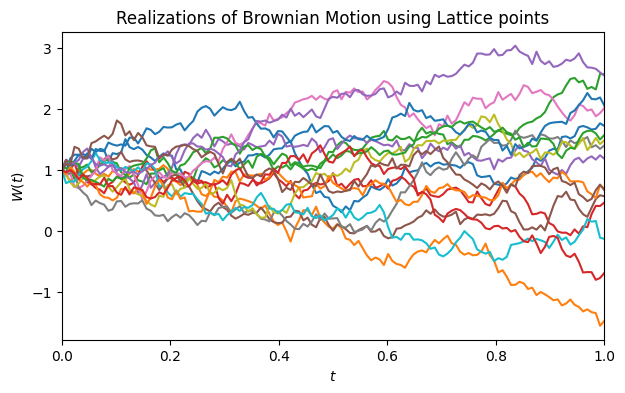

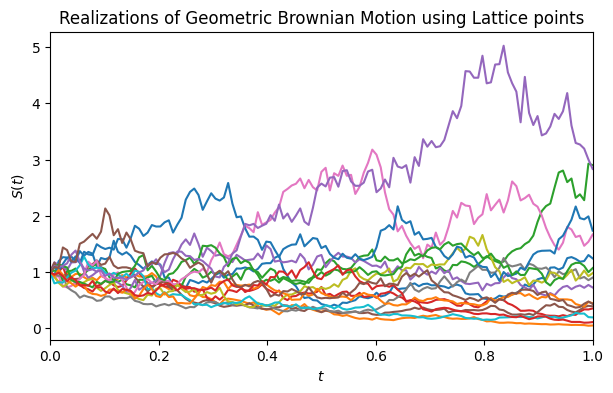

In [10]:
# Compare Brownian Motion and Geometric Brownian Motion using the unified plotting function
n = 16
sampler = qp.Lattice(2**7, seed=42)
plot_paths('BM', sampler, t_final=1, initial_value=1, drift=0, diffusion=1, n=n, png_filename='figure_1')
plot_paths('GBM', sampler, t_final=1, initial_value=1, drift=0, diffusion=1, n=n, png_filename='figure_2')

Now, using `plot_gbm_paths`, we generate 32 GBM paths to model stock price, $S(t)$, with initial value $S_0$ = 50, drift coeffient, $\mu = 0.1$, diffusion coefficient $\sigma = 0.2$ using IID points.

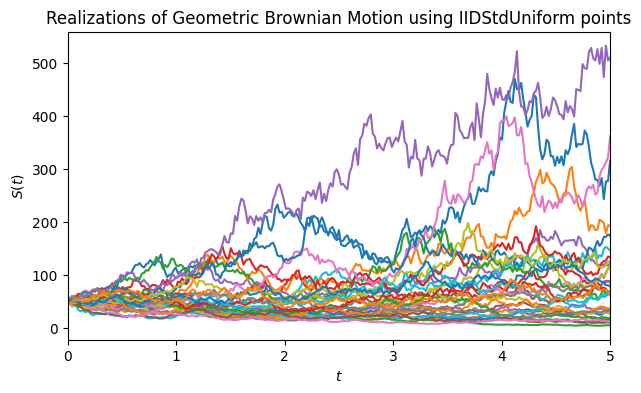

In [11]:
gbm_iid = plot_paths('GBM', qp.IIDStdUniform(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32, png_filename='figure_3')

## GBM Using Low-Discrepancy Lattice Sequence Distrubtion 

Using the same parameter values as in example above, we generate 32 GBM paths to model stock price using low-discrepancy lattice points:

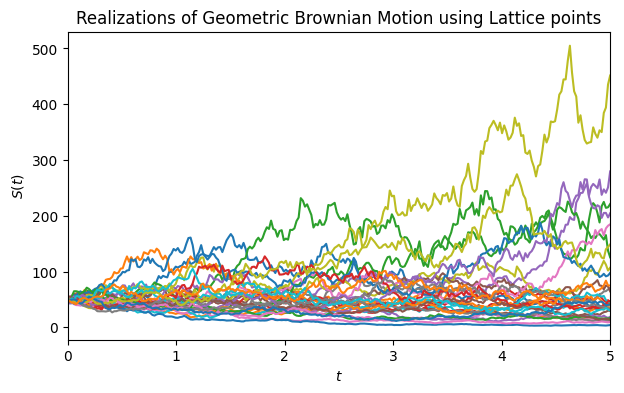

In [12]:
gbm_lattice = plot_paths('GBM', qp.Lattice(2**8), t_final=5, initial_value=50, drift=0.1, diffusion=0.2, n=32, png_filename='figure_4')

Next, we define a more sophisticated visualization function that combines path plotting with statistical analysis by showing both the GBM trajectories and the distribution of final values:

In [13]:

def plot_gbm_paths_with_distribution(N, sampler, t_final, initial_value, drift, diffusion,n):
    gbm = qp.GeometricBrownianMotion(sampler, t_final=t_final, initial_value=initial_value, drift=drift, diffusion=diffusion)
    gbm_path = gbm.gen_samples(2**n)
    
    _, ax = plt.subplots(figsize=(14, 7))
    T = max(gbm.time_vec)
    
    # Plot GBM paths
    _ = ax.plot(gbm.time_vec, gbm_path.T, lw=0.75, alpha=0.7, color='skyblue')
    
    # Set up main plot
    _ = ax.set_title(f'Geometric Brownian Motion Paths\n{N} Simulations, T = {T}, $\mu$ = {drift:.1f}, $\sigma$ = {diffusion:.1f}, using {type(sampler).__name__} points')
    _ = ax.set_xlabel(r'$t$')
    _ = ax.set_ylabel(r'$S(t)$')
    _ = ax.set_ylim(bottom=0)
    _ = ax.set_xlim(0, T)
    
    # Add histogram
    final_values = gbm_path[:, -1]
    hist_ax = ax.inset_axes([1.05, 0., 0.5, 1])
    _ = hist_ax.hist(final_values, bins=20, density=True, alpha=0.5, color='skyblue', orientation='horizontal')
    
    # Add theoretical lognormal PDF
    shape, _, scale = sc.lognorm.fit(final_values, floc=0)
    x = np.linspace(0, max(final_values), 1000)
    pdf = sc.lognorm.pdf(x, shape, loc=0, scale=scale)
    _ = hist_ax.plot(pdf, x, 'r-', lw=2, label='Lognormal PDF')
    
    # Finalize histogram
    _ = hist_ax.set_title(f'E[$S_T$] = {np.mean(final_values):.4f}', pad=20)
    _ = hist_ax.axhline(np.mean(final_values), color='blue', linestyle='--', lw=1.5, label=r'$E[S_T]$')
    _ = hist_ax.set_yticks([])
    _ = hist_ax.set_xlabel('Density')
    _ = hist_ax.legend()
    _ = hist_ax.set_ylim(bottom=0)
    plt.tight_layout()  
    plt.show();

## Interactive Visualization

The following code defines a set of sliders to control parameters for simulating paths of GBM. It sets the machine epsilon (eps) as the minimum value for `initial_value`,  `t_final`, and `diffusion`, ensuring they are always positive.  The function `plot_gbm_paths_with_distribution` then visualizes the GBM paths based on the specified parameters in the left subplot and fits a lognormal distribution to the histogram of the data values at the final time point in the right subplot.

In [14]:
eps = np.finfo(float).eps
slider_style = {'handle_color': 'blue'}

@widgets.interact
def f(n=widgets.IntSlider(min=0, max=8, step=1, value=7, style=slider_style),
      t_final=widgets.FloatSlider(min=eps, max=10, step=0.1, value=5.0, style=slider_style),
      initial_value=widgets.FloatSlider(min=eps, max=100, step=0.1, value=40, style=slider_style),
      drift=widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.1, style=slider_style),
      diffusion=widgets.FloatSlider(min=eps, max=4, step=0.1, value=0.2, style=slider_style),
      sampler=widgets.Dropdown(options=['IIDStdUniform', 'Lattice','Halton','Sobol'], value='IIDStdUniform', description='Sampler')
):
      sampler_instance = qpu.create_qmcpy_sampler(sampler, 2**n)
      plot_gbm_paths_with_distribution(2**n, sampler_instance, t_final=t_final, initial_value=initial_value, drift=drift, 
                                    diffusion=diffusion, n=n)

interactive(children=(IntSlider(value=7, description='n', max=8, style=SliderStyle(handle_color='blue')), Floa…

## QuantLib vs QMCPy Comparison

In this section, we compare QMCPy's GeometricBrownianMotion implementation with the industry-standard QuantLib library [6] to validate its accuracy and performance.

In [15]:
try:
    import QuantLib as ql
except ModuleNotFoundError:
    !pip install -q QuantLib

In [16]:
def compute_theoretical_covariance(S0, mu, sigma, t1, t2):
    """Compute theoretical covariance matrix for GBM at two time points"""
    return np.array([
        [S0**2 * np.exp(2*mu*t1) * (np.exp(sigma**2 * t1) - 1), 
         S0**2 * np.exp(mu*(t1+t2)) * (np.exp(sigma**2 * t1) - 1)],
        [S0**2 * np.exp(mu*(t1+t2)) * (np.exp(sigma**2 * t1) - 1), 
         S0**2 * np.exp(2*mu*t2) * (np.exp(sigma**2 * t2) - 1)]
    ])

def calculate_theoretical_statistics(params):
    """Calculate theoretical mean and std for GBM"""
    theoretical_mean = params['initial_value'] * np.exp(params['mu'] * params['maturity'])
    theoretical_std = np.sqrt(params['initial_value']**2 * np.exp(2*params['mu']*params['maturity']) * (np.exp(params['sigma']**2 * params['maturity']) - 1))
    return theoretical_mean, theoretical_std

#======= Parameters for GBM comparison
results_data = []
params_ql = {'initial_value': 100, 'mu': 0.05, 'sigma': 0.2, 'maturity': 1.0}
theoretical_mean, theoretical_std = calculate_theoretical_statistics(params_ql)

# Add theoretical values once
du.add_theoretical_results(results_data, theoretical_mean, theoretical_std)

# Process each sampler
for sampler_type in ['IIDStdUniform', 'Sobol', 'Lattice', 'Halton']:
    quantlib_paths, qmcpy_paths, qp_gbm, params_ql = du.process_sampler_data(sampler_type, results_data, theoretical_mean, theoretical_std)

# Create DataFrame
results_df = pd.DataFrame(results_data)
results_df.round(4)

# Store variables for visualization cell (extract individual values from params)
paths, qmcpy_paths = quantlib_paths, qmcpy_paths
initial_value = params_ql['initial_value']
mu = params_ql['mu']
sigma = params_ql['sigma']
maturity = params_ql['maturity']
n_steps = params_ql['n_steps']

,Method,Sampler,Mean,Std Dev,Mean Error,Std Dev Error
0,Theoretical,-,105.1271,21.2374,0.0000,0.0000
1,QuantLib,IIDStdUniform,105.3313,21.4671,0.2042,0.2296
2,QMCPy,IIDStdUniform,105.1443,21.3848,0.0172,0.1474
3,QuantLib,Sobol,105.0986,21.1028,0.0286,0.1346
4,QMCPy,Sobol,105.1274,21.2337,0.0003,0.0037
5,QMCPy,Lattice,105.1284,21.2460,0.0013,0.0085
6,QMCPy,Halton,105.1271,21.2337,0.0000,0.0037


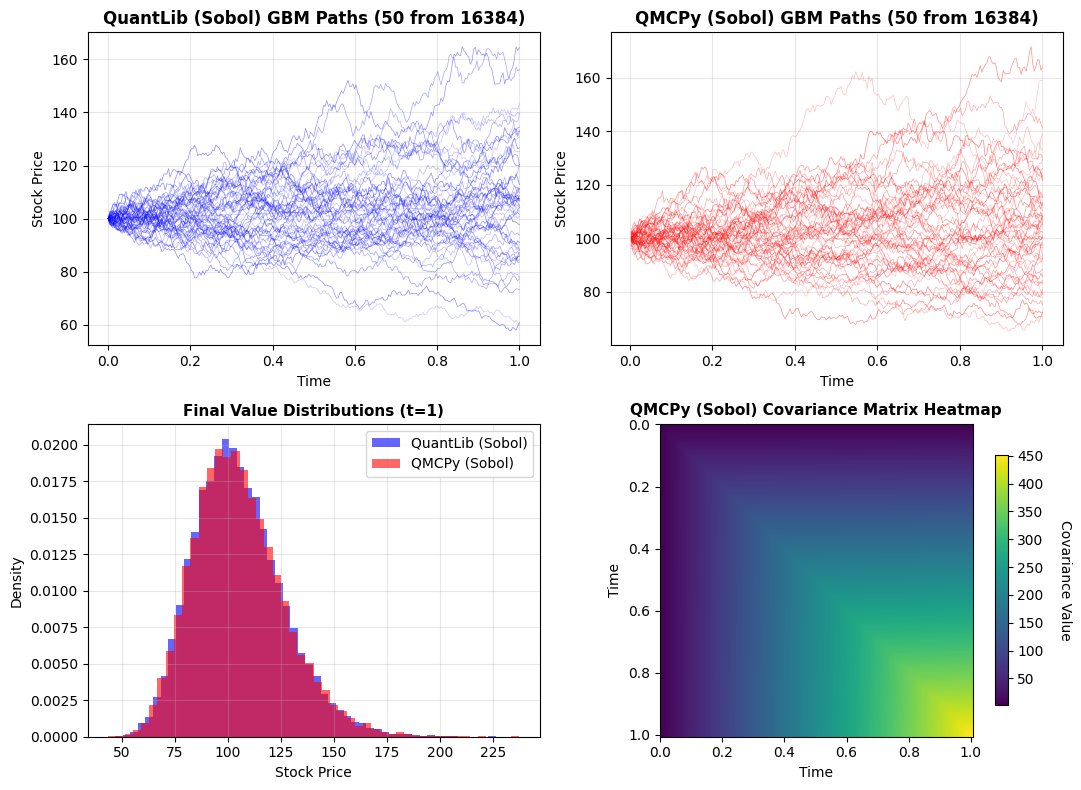

In [17]:
# Visualization 
n_plot=50   # Number of paths to plot
def plot_paths_on_axis(ax, time_vec, paths_data, title, color, n_plot=50):
    """Helper function to plot GBM paths on a given axis"""
    if paths_data is not None:
        for i in range(min(n_plot, paths_data.shape[0])):
            ax.plot(time_vec, paths_data[i, :], alpha=0.2 + 0.3 * (i / n_plot), color=color, linewidth=0.5)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock Price')
    ax.grid(True, alpha=0.3)

# Create comparison visualization with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 8))
sampler_type = "Sobol"
ql_sampler = sampler_type  
qp_sampler = sampler_type  

# Generate specific data for visualization (ensure we have data for both libraries)
params_vis_ql = {'initial_value': 100, 'mu': 0.05, 'sigma': 0.2, 'maturity': 1.0, 'n_steps': 252, 'n_paths': 2**14, 'sampler_type': 'Sobol'}
params_vis_qp = {'initial_value': 100, 'mu': 0.05, 'diffusion': 0.2**2, 'maturity': 1.0, 'n_steps': 252, 'n_paths': 2**14, 'sampler_type': 'Sobol'}

# Generate paths for visualization
vis_quantlib_paths, _ = qlu.generate_quantlib_paths(**params_vis_ql)
vis_qmcpy_paths, vis_qp_gbm = qpu.generate_qmcpy_paths(**params_vis_qp)
vis_quantlib_final = vis_quantlib_paths[:, -1]
vis_qmcpy_final = vis_qmcpy_paths[:, -1]

# Get number of samples for titles
n_samples = vis_quantlib_paths.shape[0] if vis_quantlib_paths is not None else vis_qmcpy_paths.shape[0]
plot_data = [ (ax1, np.linspace(0, maturity, n_steps + 1), vis_quantlib_paths, f'QuantLib ({ql_sampler}) GBM Paths ({n_plot} from {n_samples})', 'blue'),
              (ax2, np.linspace(maturity/n_steps, maturity, n_steps), vis_qmcpy_paths, f'QMCPy ({qp_sampler}) GBM Paths ({n_plot} from {n_samples})', 'red') ]
for ax, time_grid, data, title, color in plot_data:
    plot_paths_on_axis(ax, time_grid, data, title, color)

# Final value distributions
for final_vals, color, label, sampler in [(vis_quantlib_final, 'blue', 'QuantLib', ql_sampler), (vis_qmcpy_final, 'red', 'QMCPy', qp_sampler)]:
    if final_vals is not None:
        ax3.hist(final_vals, bins=50, alpha=0.6, color=color, label=f'{label} ({sampler})', density=True)
ax3.set_title(f'Final Value Distributions (t=1)', fontsize=11, fontweight='bold')
ax3.set_xlabel('Stock Price')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# QMCPy covariance matrix heatmap
im = ax4.imshow(vis_qp_gbm.covariance_gbm, cmap='viridis', aspect='equal') # origin='lower'
ax4.set_title(f'QMCPy ({qp_sampler}) Covariance Matrix Heatmap', fontsize=11, fontweight='bold')
ax4.set_xlabel('Time')
ax4.set_ylabel('Time')

# Set custom tick labels using time_vec
time_ticks = np.arange(0, len(vis_qp_gbm.time_vec), max(1, len(vis_qp_gbm.time_vec)//5))  # Show ~5 ticks
ax4.set_xticks(time_ticks)
ax4.set_yticks(time_ticks)
ax4.set_xticklabels([f'{vis_qp_gbm.time_vec[i]:.1f}' for i in time_ticks])
ax4.set_yticklabels([f'{vis_qp_gbm.time_vec[i]:.1f}' for i in time_ticks])
cbar = plt.colorbar(im, ax=ax4, shrink=0.8)   # Add colorbar
cbar.set_label('Covariance Value', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('images/figure_5.png', bbox_inches='tight')
plt.show();

For benchmarking, we can use IPython's built-in `%timeit` magic command which automatically handles warm-up, multiple runs, and statistical analysis. 

In [18]:
def benchmark_quantlib_samplers(samplers_to_test, base_params):
    """Benchmark QuantLib with different samplers"""
    timing_results = {}
    for sampler_type in samplers_to_test:
        print(f"QuantLib ({sampler_type}) timing:")
        benchmark_func = lambda st=sampler_type: qlu.generate_quantlib_paths(**base_params, sampler_type=st)
        timing_result = %timeit -n 10 -r 1 -o benchmark_func()
        timing_results[sampler_type] = {
            'average': timing_result.average,
            'stdev': timing_result.stdev,
            'loops': timing_result.loops,
            'repeat': timing_result.repeat
        }
    return timing_results

def benchmark_qmcpy_samplers(samplers_to_test, base_params):
    """Benchmark QMCPy samplers with timing measurements"""
    timing_results = {}
    
    # Convert QuantLib parameters to QMCPy parameters if needed
    qp_params = base_params.copy()
    if 'sigma' in qp_params:
        qp_params['diffusion'] = qp_params.pop('sigma') ** 2  # Convert sigma to diffusion (sigma²)
    
    for sampler_type in samplers_to_test:
        print(f"QMCPy ({sampler_type}) timing:")
        benchmark_func = lambda st=sampler_type: qpu.generate_qmcpy_paths(**qp_params, sampler_type=st)
        timing_result = %timeit -n 10 -r 1 -o benchmark_func()
        timing_results[sampler_type] = {
            'average': timing_result.average,
            'stdev': timing_result.stdev,
            'loops': timing_result.loops,
            'repeat': timing_result.repeat
        }
    return timing_results

In [19]:
# Benchmark QuantLib and QMCPy with different samplers
quantlib_samplers_to_benchmark = ['IIDStdUniform', 'Sobol']
qmcpy_samplers_to_benchmark = ['IIDStdUniform', 'Sobol', 'Lattice', 'Halton']
# Create base params without sampler_type to avoid conflicts  
base_ql_params = {k: v for k, v in params_ql.items() if k != 'sampler_type'}
# Add the required parameters for QMCPy benchmarking
base_ql_params.update({'n_steps': 252, 'n_paths': 2**14})
# Create QMCPy parameters (note: diffusion instead of sigma)
base_qp_params = {
    'initial_value': 100, 
    'mu': 0.05, 
    'diffusion': 0.2**2,  # sigma^2 for QMCPy
    'maturity': 1.0, 
    'n_steps': 252, 
    'n_paths': 2**14
}
# Run benchmarks
quantlib_timing_results = benchmark_quantlib_samplers(quantlib_samplers_to_benchmark, base_ql_params)
qmcpy_timing_results = benchmark_qmcpy_samplers(qmcpy_samplers_to_benchmark, base_qp_params)
# Create comprehensive timing table
timing_df = du.create_timing_dataframe(quantlib_timing_results, qmcpy_timing_results, quantlib_samplers_to_benchmark[0])
timing_df.round(4)

QuantLib (IIDStdUniform) timing:
833 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
QuantLib (Sobol) timing:
893 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
QMCPy (IIDStdUniform) timing:
797 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
QMCPy (Sobol) timing:
777 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
QMCPy (Lattice) timing:
766 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
QMCPy (Halton) timing:
2.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


,Method,Sampler,Mean Time (s),Std Dev (s),Speedup
0,QuantLib,IIDStdUniform,0.8331,0.0,-
1,QuantLib,Sobol,0.8930,0.0,-
2,QMCPy,IIDStdUniform,0.7965,0.0,1.045952
3,QMCPy,Sobol,0.7773,0.0,1.071847
4,QMCPy,Lattice,0.7661,0.0,1.087475
5,QMCPy,Halton,2.4715,0.0,0.337098


In [20]:
# Output results to LaTeX
results_df = pd.merge(results_df, timing_df, on=['Method', 'Sampler'])
# Format the results dataframe
numeric_cols = ['Mean', 'Std Dev', 'Mean Error', 'Std Dev Error', 'Mean Time (s)', 'Std Dev (s)', 'Speedup']
results_formatted = lu.format_results_dataframe(results_df, numeric_cols)
# Generate and save LaTeX table
title =  "GBM Final Value Statistics and Performance Comparison"
latex_table = lu.generate_latex_table(results_formatted, title, "tab2")
with open('outputs/gbm_comparison_table.tex', 'w') as f:
    f.write(latex_table)

917

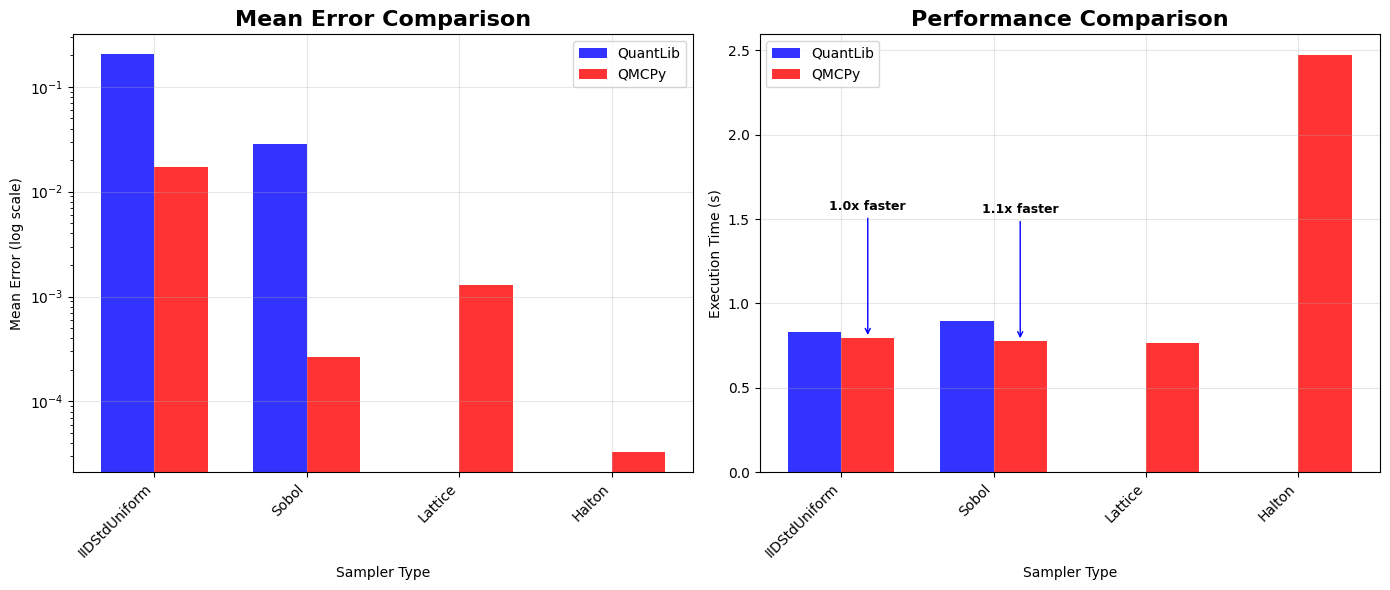

In [21]:
# Create comparison plot using sample data (2 subplots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Extract data for plotting
samplers, qmcpy_errors, qmcpy_times, quantlib_errors, quantlib_times, theoretical_mean = du.extract_comparison_data(results_df)
# Create subplots 
pu.plot_error_comparison(ax1, samplers, qmcpy_errors, quantlib_errors)
pu.plot_performance_comparison(ax2, samplers, qmcpy_times, quantlib_times)
plt.tight_layout()
plt.savefig('images/figure_6.png', bbox_inches='tight', dpi=150)
plt.show()

In [22]:
%%capture
# ========================================
# MAIN EXPERIMENT RUNNER
# ========================================
def run_single_configuration(series_name, n_steps, n_paths):
    """Run benchmarking for a single parameter configuration"""
    print(f"\nTesting n_steps = {n_steps}, n_paths = {n_paths}")
    
    # Calculate theoretical values
    gbm_params = cf.get_gbm_parameters()
    theoretical_mean, theoretical_std = calculate_theoretical_statistics(gbm_params)
    
    # Prepare benchmark parameters for QuantLib (with sigma)
    ql_params = {**gbm_params, 'n_steps': n_steps, 'n_paths': n_paths}
    
    # Prepare benchmark parameters for QMCPy (with diffusion instead of sigma)
    qp_params = {
        'initial_value': gbm_params['initial_value'],
        'mu': gbm_params['mu'],
        'diffusion': gbm_params['sigma']**2,  # Convert sigma to diffusion
        'maturity': gbm_params['maturity'],
        'n_steps': n_steps,
        'n_paths': n_paths
    }
    
    # Run benchmarks
    samplers = cf.get_sampler_configurations()
    print("  Benchmarking QuantLib...")
    ql_timing = benchmark_quantlib_samplers(samplers['quantlib_samplers'], ql_params)
    
    print("  Benchmarking QMCPy...")
    qp_timing = benchmark_qmcpy_samplers(samplers['all_samplers'], qp_params)
    
    # Collect results for all samplers
    results = []
    du.add_theoretical_row(results, series_name, n_steps, n_paths, theoretical_mean, theoretical_std)
    
    for sampler in samplers['all_samplers']:
        print(f"    Processing {sampler}...")
        sampler_results = du.collect_library_results(
            sampler, series_name, n_steps, n_paths,
            ql_timing, qp_timing, theoretical_mean, theoretical_std
        )
        results.extend(sampler_results)
    
    return results

def run_time_steps_series():
    """Run experiments varying time steps with fixed paths"""
    config = cf.get_experiment_configurations()['time_steps']
    print(f"\nSERIES 1: Varying Time Steps (n_paths fixed at {config['fixed_paths']})")
    print("-" * 60)
    
    all_results = []
    for n_steps in config['range']:
        results = run_single_configuration(
            config['series_name'], n_steps, config['fixed_paths']
        )
        all_results.extend(results)
    
    return all_results

def run_paths_series():
    """Run experiments varying paths with fixed time steps"""
    config = cf.get_experiment_configurations()['paths']
    print(f"\nSERIES 2: Varying Number of Paths (n_steps fixed at {config['fixed_steps']})")
    print("-" * 60)
    
    all_results = []
    for n_paths in config['range']:
        results = run_single_configuration(
            config['series_name'], config['fixed_steps'], n_paths
        )
        all_results.extend(results)
    
    return all_results

def run_comprehensive_parameter_sweep():
    """
    Run comprehensive parameter sweep experiments:
    1. Vary time steps with fixed paths
    2. Vary paths with fixed time steps
    """
    all_results = []
    all_results.extend(run_time_steps_series())
    all_results.extend(run_paths_series())
    
    return pd.DataFrame(all_results)

# ========================================
# MAIN EXECUTION
# ========================================

# Run the comprehensive parameter sweep
print("Starting comprehensive parameter sweep experiments...")
sweep_results_df = run_comprehensive_parameter_sweep()

# Display summary results
print(f"\nExperiment completed! Total data points collected: {len(sweep_results_df)}")
print(f"Unique configurations tested: {len(sweep_results_df.groupby(['Series', 'n_steps', 'n_paths']))}")

# Create visualizations
pu.create_parameter_sweep_plots(sweep_results_df)

# Display sample of results
print("\nSample of results:")
sample_results = sweep_results_df[sweep_results_df['Method'] != 'Theoretical'].head(10)
print(sample_results[['Series', 'n_steps', 'n_paths', 'Method', 'Sampler', 'Runtime (s)', 'Mean Error']].round(6))

# Save results for later analysis
sweep_results_df.to_csv('outputs/parameter_sweep_results.csv', index=False)
print(f"\nFull results saved to: outputs/parameter_sweep_results.csv")

**QMCPy vs QuantLib:** Both libraries produce statistically equivalent GBM simulations that match theoretical values. QMCPy typically runs 1.5 to 3 times faster due to vectorized operations, making it excellent for research and high-performance applications. QuantLib remains the industry standard for production systems requiring comprehensive derivatives support.

In [23]:
# If you need different samplers, create efficiently
base_params = {'t_final': 1, 'initial_value': 100, 'drift': 0.05, 'diffusion': 0.2}

sobol_gbm = qp.GeometricBrownianMotion(qp.Sobol(252), **base_params)
lattice_gbm = qp.GeometricBrownianMotion(qp.Lattice(252), **base_params)
halton_gbm = qp.GeometricBrownianMotion(qp.Halton(252), **base_params)

## References

* $[1]$ Glasserman, P. (2003). *Monte Carlo Methods in Financial Engineering*. Springer.
* $[2]$ Choi, S.-C. T., Hickernell, F. J., Jagadeeswaran, R., McCourt, M. J., and Sorokin, A. G. (2022). Quasi-Monte Carlo Software. In Alexander Keller, editor, *Monte Carlo and Quasi-Monte Carlo Methods*. Springer International Publishing.
* $[3]$ Choi, S.-C. T., Hickernell, F. J., Jagadeeswaran, R., McCourt, M., and Sorokin, A. (2020--2025). QMCPy: A quasi-Monte Carlo Python Library (versions 2). https://qmcpy.readthedocs.io/.
* $[4]$ Hull, J. C. (2017). *Options, Futures, and Other Derivatives*. Pearson, 10th edition.
* $[5]$ Ross, S. M. (2014). *Introduction to Probability Models*. Academic Press, 11th edition.
* $[6]$ The QuantLib contributors (2003--2025). QuantLib: A free/open-source library for quantitative finance, Version 1.38. https://www.quantlib.org.

## Appendix: Covariance Matrix Derivation for Geometric Brownian Motion

Here we derive the covariance matrix of $(S(t_1), \ldots , S(t_n))$ for one-dimensional Geometric Brownian Motion defined as $S(t) = S_0 \, e^{\big(\mu - \frac{\sigma^2}{2}\big)  t + \sigma W(t)}$, where $W(t)$ is a standard one-dimensional Brownian motion.


1.  **Recall the definition of covariance:**
    $$\text{Cov}(S(t_i), S(t_j)) = E[S(t_i)S(t_j)] - E[S(t_i)]E[S(t_j)].$$

2.  **Calculate the product of expectations:**
    The expected value of $S(t)$ is $E[S(t)] = S_0 e^{\mu t}$.
    Therefore, the product of the expectations is:
    $$E[S(t_i)]E[S(t_j)] = (S_0 e^{\mu t_i})(S_0 e^{\mu t_j}) = S_0^2 e^{\mu(t_i + t_j)}$$

3.  **Calculate the expectation of the product, $E[S(t_i)S(t_j)]$:**
    $$\begin{aligned}
    S(t_i)S(t_j) &= S_0 e^{(\mu - \frac{\sigma^2}{2})t_i + \sigma W(t_i)} \cdot S_0 e^{(\mu - \frac{\sigma^2}{2})t_j + \sigma W(t_j)} \\
    &= S_0^2 \exp\left( (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma \left(W(t_i) + W(t_j) \right) \right)
    \end{aligned}$$
    The exponent is a normal random variable. Let's call it $Y$:
    $$Y = (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma\left(W(t_i) + W(t_j)\right)$$
    To find the expectation of $e^Y$, we use the property that if $Y \sim N(\text{mean}, \text{variance})$, then $E[e^Y] = e^{\text{mean} + \frac{1}{2}\text{variance}}$.

    * The mean of $Y$ is
        $E[Y] = E[(\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma(W(t_i) + W(t_j))] = (\mu - \frac{\sigma^2}{2})(t_i + t_j).$

    * The variance of $Y$ is
        $$\begin{aligned}
        \text{Var}(Y) &= \text{Var}[(\mu - \frac{\sigma^2}{2})(t_i + t_j) + \sigma(W(t_i) + W(t_j))] \\
        &= \text{Var}[\sigma(W(t_i) + W(t_j))] \\
        &= \sigma^2 \text{Var}(W(t_i) + W(t_j)) \\
        &= \sigma^2(\text{Var}(W(t_i)) + \text{Var}(W(t_j)) + 2\text{Cov}(W(t_i), W(t_j))) \\
        &= \sigma^2(t_i + t_j + 2\min(t_i, t_j))
         \end{aligned}$$
    Now we can compute $E[S(t_i)S(t_j)] = S_0^2 E[e^Y]$:
    $$\begin{aligned}
    E[S(t_i)S(t_j)] &= S_0^2 \exp\left( E[Y] + \frac{1}{2}\text{Var}(Y) \right) \\
    &= S_0^2 \exp\left( (\mu - \frac{\sigma^2}{2})(t_i + t_j) + \frac{1}{2}\sigma^2 \left(t_i + t_j + 2\min(t_i, t_j)\right) \right)
    \end{aligned}$$
    Simplifying the exponent:
    $$\begin{aligned}
    &\mu(t_i + t_j) - \frac{\sigma^2}{2}(t_i+t_j) + \frac{\sigma^2}{2}(t_i+t_j) + \sigma^2\min(t_i,t_j) \\
    &= \mu(t_i + t_j) + \sigma^2\min(t_i,t_j)
    \end{aligned}$$
    So, the final expression for the expectation of the product is:
    $$E[S(t_i)S(t_j)] = S_0^2 e^{\mu(t_i + t_j) + \sigma^2\min(t_i, t_j)}$$

4.  **Combine the terms to get the covariance:**
    $$\begin{aligned}
    \text{Cov}(S(t_i), S(t_j)) &= S_0^2 e^{\mu(t_i + t_j) + \sigma^2\min(t_i, t_j)} - S_0^2 e^{\mu(t_i + t_j)} \\
    &= S_0^2 e^{\mu(t_i + t_j)} \left(e^{\sigma^2 \min(t_i, t_j)} - 1\right).
    \end{aligned}$$